# Strojenie parametrów - czyli jak znaleźć najlepszy model?

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123) 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['font.size'] = 14

### Wczytanie danych i podział na train-test

In [3]:
data=pd.read_csv('heart.csv')

y = np.array(data['chd'])
X = data.drop(['chd'],axis=1)

map_dict = {'Present': 1, 'Absent':0}
X['famhist'] = X['famhist'].map(map_dict)
X.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2)

### Drzewo decyzyjne

In [5]:
from sklearn.tree import DecisionTreeClassifier
#parametry domyślne
tree_model= DecisionTreeClassifier()

tree_model.fit(X_train, y_train).score(X_test, y_test)

0.6344086021505376

## Po co to wszystko?

![image.png](http://snoek.ddns.net/~oliver/mysite/images/blog7_accuracyprecision_banner.png)
http://snoek.ddns.net/~oliver/mysite/the-bias-variance-tradeoff.html

### Jak zdiagnozować problem? Learning Curves

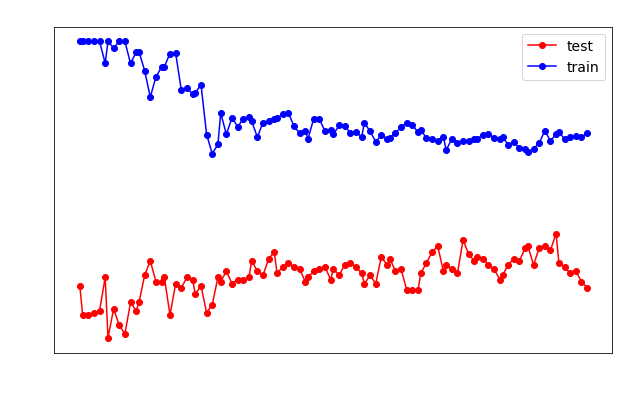

In [6]:
from sklearn.model_selection import learning_curve
tree_model= DecisionTreeClassifier(max_depth=5)
train_sizes, train_scores, test_scores = \
    learning_curve(tree_model, X_train[:300], y_train[:300], train_sizes=np.linspace(0.1, 1, 100),
                   scoring="accuracy", cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="test")
plt.plot(train_sizes, train_scores.mean(1), 'o-', color="b",
         label="train")


plt.xlabel("Train size")
plt.ylabel("Accuracy")
plt.title('Learning curves')
plt.legend(loc="best")
l = ax.legend()
for text in l.get_texts():
    text.set_color("black")

plt.show()

### Diagnoza: High Variance

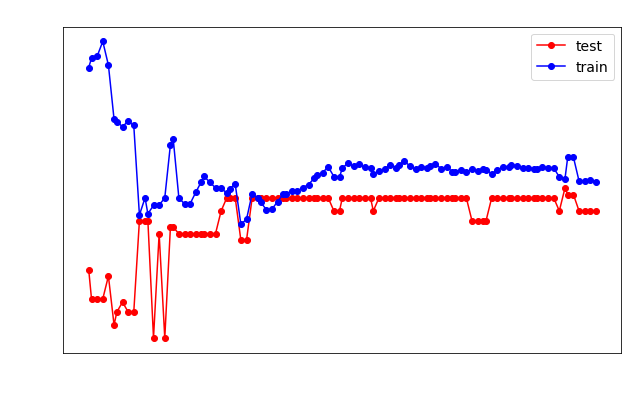

In [7]:
from sklearn.model_selection import learning_curve
tree_model= DecisionTreeClassifier(max_depth=1)
train_sizes, train_scores, test_scores = \
    learning_curve(tree_model, X_train[:300], y_train[:300], train_sizes=np.linspace(0.1, 1, 100),
                   scoring="accuracy", cv=3)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         
         label="test")
plt.plot(train_sizes, train_scores.mean(1), 'o-', color="b",
         label="train")


plt.xlabel("Train size")
plt.ylabel("Accuracy")
plt.title('Learning curves')
plt.legend(loc="best")
l = ax.legend()
for text in l.get_texts():
    text.set_color("black")

plt.show()

### Powyżej mamy High Bias
Andrew Ng: https://www.youtube.com/watch?v=ISBGFY-gBug&t=344s

### Kroswalidacja

In [8]:
import sklearn
from sklearn.model_selection import cross_val_score
tree_model= DecisionTreeClassifier()
results=cross_val_score(tree_model, X, y) # można zdefiniować: scoring='roc_auc'
# uwaga: tutaj nie strojono parametrów więc można użyć całego zbioru
print(np.mean(results), np.std(results))

0.6601449275362319 0.01798940865300251


In [9]:
# mamy wiele możliwych metryk
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## Przeszukiwanie przestrzeni parametrów

### Grid Search
Klasyczne przeszukiwanie wszystkich możliwości

#### Zalety:
* sprawdzimy wszystkie kombinacje

#### Wady:
* musimy wiedzieć jakie konkretnie kombinacje chcemy sprawdzić
* długo trwa

In [10]:
from sklearn.model_selection import GridSearchCV

max_depth=[3, 5, 6]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05]
param_grid = dict(max_depth=max_depth,criterion=criterion, ccp_alpha=ccp_alpha)

In [11]:
tree_model= DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv = 3, n_jobs=-1)

grid_result = grid.fit(X_train, y_train) #tutaj lepiej zastosować tylko trainset

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.680217 using {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 3}


In [12]:
grid_result.best_estimator_.score(X_test, y_test)

0.6666666666666666

### Random Search 

In [13]:
from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, cv = 3, n_jobs=-1)

random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.680217 using {'max_depth': 3, 'criterion': 'gini', 'ccp_alpha': 0}


In [14]:
best_model=random_result.best_estimator_
best_model.score(X_test, y_test)

0.6666666666666666

Zauważmy, że tu mało się zmienia. Nadal przeszukujemy siatkę, ale w sposób losowy. Nasza siatka jest dość mała, więc i tak sprawdzamy wszystkie możliwości

## Zdefiniowanie rozkładów

<div>
<img src="https://ksopyla.com/wp-content/uploads/2018/12/Grid_search_vs_random_search_cross_validation.png" width="800"/>
</div>

sos: https://ksopyla.com/machine-learning/grid-random-search-scikit-learn-dobor-parametrow/

In [15]:
from scipy.stats import poisson,expon
param_grid = {'ccp_alpha': expon(0.08),
             'max_depth': poisson(5)}

In [16]:
random = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, cv = 3, n_jobs=-1, random_state=123)

random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.655827 using {'ccp_alpha': 1.2722721434811057, 'max_depth': 7}


In [17]:
random_result.best_estimator_.score(X_test, y_test)

0.6451612903225806

## Bayes optimization
Bardziej inteligentne przeszukiwanie na podstawie Gaussian process

In [18]:
#!pip install scikit-optimize
#!pip install --upgrade scikit-learn==0.23.2
#Jest problem z najnowszą wersją sklearn

In [19]:
from skopt import BayesSearchCV
from sklearn.svm import SVC

opt = BayesSearchCV(
    SVC(),
    {
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=8, # tu powinno być więcej, ale to się długo liczy
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.7018970189701897
test score: 0.7526881720430108


Przykład pochodzi stąd: https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html  
Tam też jest więcej parametrów

# Są narzędzia, które robią wszystko za nas

## automl from sklearn
(działa tylko na Linuxie - rozwiązanie: korzystać z Google Colaboratory)  
Nie ma na Anacondzie, wymaga sklearn >= 0.24

In [20]:
#import autosklearn.classification
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)
y_pred = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))

NameError: name 'autosklearn' is not defined

Jak widać trudno się czasem dogadać ze wszystkimi pakietami...

### TPOT
https://epistasislab.github.io/tpot/  
Korzysta z algorytmów genetycznych

![image.png](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1537396029/output_2_0_d7uh0v.png)
https://www.datacamp.com/community/tutorials/tpot-machine-learning-python

In [ ]:
# ! pip install tpot

In [21]:
from tpot import TPOTClassifier
#from tpot import TPOTRegressor

tpot = TPOTClassifier(generations=5,verbosity=2)

tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.7210662717512032

Generation 2 - Current best internal CV score: 0.7210662717512032

Generation 3 - Current best internal CV score: 0.7237319511292114

Generation 4 - Current best internal CV score: 0.7237319511292114

Generation 5 - Current best internal CV score: 0.7345427619400222

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=5, min_samples_split=20, n_estimators=100)


TPOTClassifier(generations=5, verbosity=2)

In [22]:
tpot.score(X_test, y_test)

0.6989247311827957

### Potencjalne wady:
- długo się liczy
- nie gwarantuje zbieżności

Trochę więcej (np. o parametrach) można poczytać tutaj https://www.datacamp.com/community/tutorials/tpot-machine-learning-python

## Selekcja zmiennych

### Filtry
Najprostsze metody, nie zależą od moeli. To jest preprocessing.

Przykłady:
- korelacja ze zmienną celu
- informacja wzajema ze zmienną celu (VIF)

## VIF
Variance Inflation Factor  
Dopasowujemy model regresji liniowej, gdzie jedna kolumna jest targetem, a pozostałe feature'ami

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
pd.DataFrame(data = [(X_train.columns[i], vif(X_train.values, i)) for i in range(X_train.shape[1])], columns=['feature', 'vif_score'])

,feature,vif_score
0,sbp,39.633703
1,tobacco,2.114713
2,ldl,8.109231
3,adiposity,37.912573
4,famhist,1.866989
5,typea,25.535142
6,obesity,64.617438
7,alcohol,1.584873
8,age,20.609623


## Metody wbudowane
czyli takie metody, które są wbudowane w algorytm - Lasso albo Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

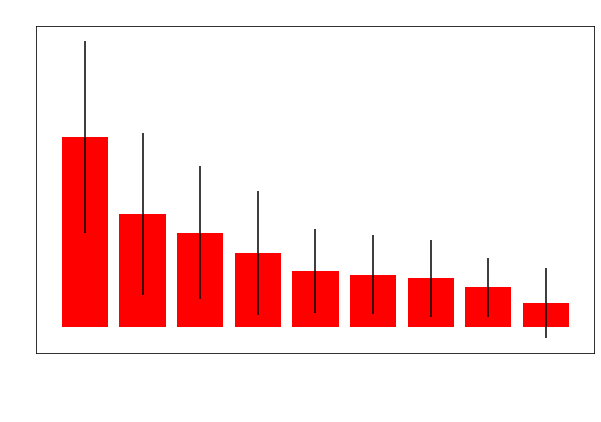

In [25]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(X.columns, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation=45)
plt.show()

### Wrappery
Oceniają poszczególne zbiory zmiennych na podstawie wybranych metryk (accuracy, AUC, ...). Zazwyczaj działa to w ten sposób, że iteracyjnie dodajemy/odejmujemy kolejne zmienne aż osiągniemy daną liczbę zmiennych/wynik modelu.   

Zasadniczo to taki model, który ocenia zmienne. Też trzeba go zfitować.

Przykłady:
- Forward Selection (K Best, Select From Model) 
- Recursive Feature Elimination
- Boruta

### SelectKBest 
Wybieramy K Najlepszych cech na podstawie zadanego kryterium  
Default: na podstawie algorytmu ANOVA

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
tree_model=DecisionTreeClassifier()

pipe = Pipeline([
    ('select', SelectKBest()),
    ('model', tree_model)])

k=[5,6]
max_depth=[3, 5, 6]
criterion=["gini","entrophy"]

# uwaga: gdy podajemy parametry do strojenia gdy mamy pipeline to trzeba w nazwach kluczy podać nazwę_danego_etapu__ 
# (poprzedzoną dwoma podkreślnikami)
param_grid = {"model__max_depth": max_depth, "model__criterion": criterion, "select__k": k}

search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

In [27]:
search.score(X_test, y_test)

0.7311827956989247

In [28]:
X_train.columns[search.best_estimator_.steps[0][1].get_support()]

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'age'], dtype='object')

### Select From Model

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
model_selector = SelectFromModel(
    LogisticRegression(C=0.000025, solver="liblinear"),
    threshold = 'mean'
)

pipe = Pipeline([
    ('select', model_selector),
    ('model', tree_model)])

penalty = ['l1', 'l2']

# tu odwołujemy się do select (SelectFromModel) i do estymatora w środku (LR), więc dwa razy podwójny podkreślnik (__)
param_grid = {"model__max_depth": max_depth, "model__criterion": criterion, "select__estimator__penalty": penalty}
search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

In [38]:
X_train.columns[search.best_estimator_.steps[0][1].get_support()]

Index(['sbp', 'tobacco', 'age'], dtype='object')

### Recursive Feature Elimination
Zasadniczo, działa tak jak brzmi. 
Dopasuj model, zobacz, która cecha jest "najmniej ważna".  
Powtórz dla modelu bez tej cechy.  

Najmniej ważna to może być względem *feature_importances* albo *coef*

In [31]:
from sklearn.feature_selection import RFE
estimator = tree_model
selector = RFE(estimator, n_features_to_select=3, step=1) #step ile (procent) cech usuwamy w kroku
selector = selector.fit(X_train, y_train) 

In [32]:
X_train.columns[selector.support_]


Index(['ldl', 'typea', 'age'], dtype='object')

### Boruta
Próbuje znaleźć *wszystkie* cechy, które mają związek z targetem

In [33]:
#!pip install boruta

In [34]:
from boruta import BorutaPy
# for classification only (we need to convert pd.DataFrame to np.array)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X_train.values, y_train)
feat_selector.support_
feat_selector.ranking_

# wybór odpowiednich zmiennych ze zbioru testowego
X_filtered = feat_selector.transform(X_test.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	3
Iteration: 	17 / 

In [36]:
X_train.columns[feat_selector.support_]

Index(['tobacco', 'ldl', 'adiposity', 'age'], dtype='object')

## Ciekawostki: 
Przykład wizualizacji dla kilku metryk 
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html   

Jak robić strojenie parametrów dla różnych modeli?
- http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
- https://stackoverflow.com/questions/50265993/alternate-different-models-in-pipeline-for-gridsearchcv  

Inny przykład automl
- Hyperopt https://hyperopt.github.io/hyperopt/

Paulina wrzuciła ten link a propos metod wbudowanych, więc nie chciałem być gorszy
- https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3